In [1]:
import os
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import pickle
import sys
from sklearn.neighbors import KernelDensity
sys.path.append('../src')
import P_random
import P_binary
import const as c
from astropy.coordinates import SkyCoord, ICRS, FK5
from astropy import units as u

%matplotlib inline

In [2]:
AU_to_cm = 1.496e13               # AU to cm
pc_to_cm = 3.086e18               # pc to cm

In [12]:
folder = '../data/TGAS/'

TGAS = np.genfromtxt(open(folder + 'gaia_wide_binaries_TGAS_plx_empirical_cleaned.txt', 'rb'), comments='#', names=True, skip_header=4)

TGAS_good = TGAS[TGAS['P_posterior'] > 0.9]

In [13]:
print TGAS.shape
print TGAS_good.shape
print TGAS.dtype

(15677,)
(6806,)
[('P_posterior', '<f8'), ('theta', '<f8'), ('source_ID_1', '<f8'), ('TYC_ID_1', '<f8'), ('HIP_ID_1', '<f8'), ('ra_1', '<f8'), ('dec_1', '<f8'), ('mu_ra_1', '<f8'), ('mu_dec_1', '<f8'), ('mu_ra_err_1', '<f8'), ('mu_dec_err_1', '<f8'), ('plx_1', '<f8'), ('plx_err_1', '<f8'), ('gaia_g_flux_1', '<f8'), ('gaia_g_flux_err_1', '<f8'), ('gaia_g_mag_1', '<f8'), ('2MASS_ID_1', '<f8'), ('2MASS_angle_dist_1', '<f8'), ('2MASS_n_neighbours_1', '<f8'), ('2MASS_n_mates_1', '<f8'), ('2MASS_ph_qual_1', '<f8'), ('2MASS_ra_1', '<f8'), ('2MASS_dec_1', '<f8'), ('2MASS_j_mag_1', '<f8'), ('2MASS_j_mag_err_1', '<f8'), ('2MASS_h_mag_1', '<f8'), ('2MASS_h_mag_err_1', '<f8'), ('2MASS_ks_mag_1', '<f8'), ('2MASS_ks_mag_err_1', '<f8'), ('Tycho_Vt_1', '<f8'), ('Tycho_Vt_err_1', '<f8'), ('Tycho_Bt_1', '<f8'), ('Tycho_Bt_err_1', '<f8'), ('Gaia_delta_Q_1', '<f8'), ('Gaia_noise_1', '<f8'), ('source_ID_2', '<f8'), ('TYC_ID_2', '<f8'), ('HIP_ID_2', '<f8'), ('ra_2', '<f8'), ('dec_2', '<f8'), ('mu_ra_2', '<f

In [6]:
TGAS_300pc = TGAS_good[TGAS_good['plx_1'] > 1.0e3/300.0]
TGAS_200pc = TGAS_good[TGAS_good['plx_1'] > 1.0e3/200.0]
TGAS_100pc = TGAS_good[TGAS_good['plx_1'] > 1.0e3/100.0]

### First, let's look at the distribution of posterior probabilities

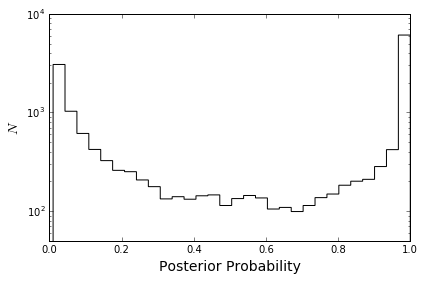

In [15]:
plt.hist(TGAS['P_posterior'], bins=30, linestyle='solid', histtype='step', color='k', log=True)


plt.xlabel('Posterior Probability', fontsize=14)
plt.ylabel(r'$N$', fontsize=14)
#plt.xlabel(r'$P\ (C_2 | \vec{x}_i, \vec{x}_j)$', fontsize=14)

plt.ylim(5.0e1, 1.0e4)

plt.tight_layout()
#plt.savefig('../figures/TGAS_P_posterior_dist.pdf')
plt.show()

### Now, the distance distribution

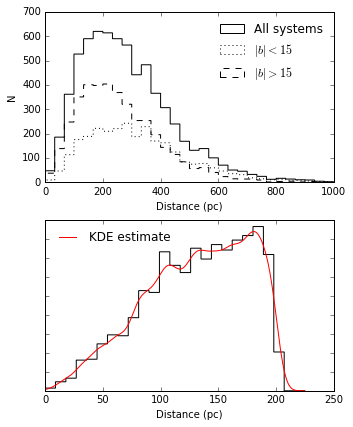

In [167]:
fig, ax = plt.subplots(2, 1, figsize=(5, 6))


# Calculate distance from average parallaxes, weighted by uncertainties
dist = np.zeros(len(TGAS_good))
for i in np.arange(len(TGAS_good)):
    vals = [TGAS_good['plx_1'][i],TGAS_good['plx_2'][i]]
    weights = [1.0/TGAS_good['plx_err_1'][i]**2,1.0/TGAS_good['plx_err_2'][i]**2]
    dist[i] = 1.0e3/np.average(vals, weights=weights)



# Determine pairs in halo and in Galactic plane
coor_icrs = SkyCoord(ra=TGAS_good['ra_1']*u.degree, dec=TGAS_good['dec_1']*u.degree, frame='icrs')
idx_plane = np.where(abs(coor_icrs.galactic.b.degree) < 15.0)
idx_halo = np.where(abs(coor_icrs.galactic.b.degree) >= 15.0)

# Plot different pairs
ax[0].hist(dist, histtype='step', color='k', bins=30, 
         range=(0, 1000), label='All systems')
ax[0].hist(dist[idx_plane], histtype='step', color='k', bins=30, 
         range=(0, 1000), linestyle='dotted', label=r'$|b|<15$')
ax[0].hist(dist[idx_halo], histtype='step', color='k', bins=30, 
         range=(0, 1000), linestyle='dashed', label=r'$|b|>15$')

ax[0].set_xlabel('Distance (pc)')
ax[0].set_ylabel('N')

ax[0].legend(frameon=False)





dist_kde = gaussian_kde(dist[dist<200.0], bw_method=0.1)

tmp_dist = np.linspace(0.0, 225.0, 200)
dist_out = dist_kde.evaluate((tmp_dist))

ax[1].hist(dist[dist<200.0], normed=True, histtype='step', color='k', bins=25, range=(0,225.0))
ax[1].plot(tmp_dist, dist_out, color='r', label='KDE estimate')
ax[1].set_xlabel('Distance (pc)')
ax[1].set_yticklabels([])
ax[1].legend(loc=2, frameon=False)





plt.tight_layout()
plt.savefig('../figures/TGAS_distance_gal_b.pdf')
#plt.show()

### Now, let's look at the angular separation distribution

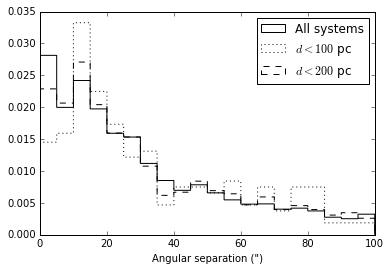

In [65]:
xmin, xmax = 0.0, 100.0

plt.hist(TGAS_good['theta'], histtype='step', color='k', linestyle='solid', bins=20, 
         range=(xmin,xmax), normed=True, label='All systems')
plt.hist(TGAS_100pc['theta'], histtype='step', color='k', linestyle='dotted', bins=20, 
         range=(xmin,xmax), normed=True, label=r'$d<100$ pc')
plt.hist(TGAS_200pc['theta'], histtype='step', color='k', linestyle='dashed', bins=20, 
         range=(xmin,xmax), normed=True, label=r'$d<200$ pc')

plt.xlim(xmin, xmax)
plt.legend()
plt.xlabel('Angular separation (")')
# plt.ylim(0,5)

plt.show()

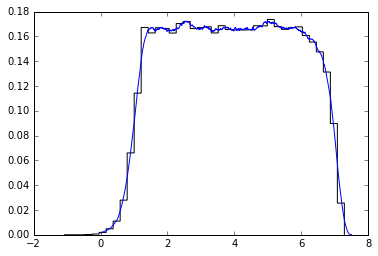

In [67]:
P_binary.generate_binary_set(num_sys=100000, ecc_prob='thermal', a_prob='log_flat')

plt.hist(np.log10(P_binary.binary_set['proj_sep']), histtype='step', color='k', bins=40, normed=True)

kwargs = {'kernel':'tophat'}
proj_sep_kde = KernelDensity(bandwidth=0.2, **kwargs)
proj_sep_kde.fit( np.log10(P_binary.binary_set['proj_sep'][:, np.newaxis] ))


#print np.exp(proj_sep_kde.score_samples(plx[:, np.newaxis]))

sep = np.linspace(0.0, 7.5, 1000)
prob_sep = np.exp(proj_sep_kde.score_samples(sep[:, np.newaxis]))

plt.plot(sep, prob_sep)
#plt.ylim(0.0, 1.0e-3)

plt.show()

In [66]:
def get_integrand(dist, angle, dist_max):
    """ Integrand. Distance in pc, angle in asec """
    
    proj_sep = (angle/3600.0*np.pi/180.0) * (dist*c.pc_to_cm/c.Rsun_to_cm)
        
    prob_proj_sep = np.exp(proj_sep_kde.score_samples(np.log10(proj_sep*np.ones(1)[:, np.newaxis]))) / (proj_sep*np.log(10.))
    
    return prob_proj_sep * 3.0 * dist**3 * dist_max**(-3)

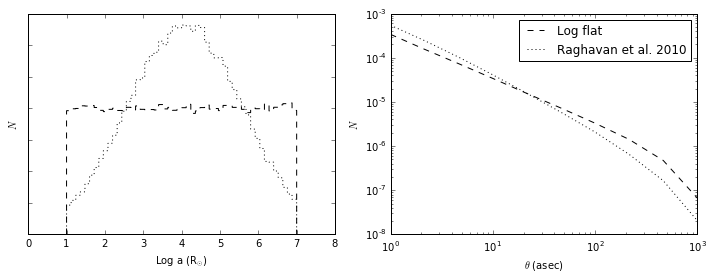

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

dist_min = 1.0
nsamples = 10
xmin = 1.0
xmax = 1000.0

log_angles = np.linspace(np.log10(xmin), np.log10(xmax), nsamples)
angles = 10**log_angles




# Flat in log-space, thermal e
P_binary.generate_binary_set(num_sys=100000, ecc_prob='thermal', a_prob='log_flat')

tmp_a = P_binary.get_a(num_sys=100000, prob='log_flat')
ax[0].hist(np.log10(tmp_a), histtype='step', color='k', bins=50, linestyle='dashed', label='Log flat')

proj_sep_kde is None
kwargs = {'kernel':'tophat'}
proj_sep_kde = KernelDensity(bandwidth=0.2, **kwargs)
proj_sep_kde.fit( np.log10(P_binary.binary_set['proj_sep'][:, np.newaxis] ))


P_theta = np.zeros(nsamples)
dist_max = 100.0
for i, ang in zip(np.arange(nsamples), angles):
    args = ang, dist_max
    P_theta[i], err_theta = quad(get_integrand, dist_min, dist_max, args=args)

ax[1].plot(angles, P_theta, color='k', linestyle='dashed', label='Log flat')






# Log-normal, thermal e
P_binary.generate_binary_set(num_sys=100000, ecc_prob='thermal', a_prob='raghavan')

tmp_a = P_binary.get_a(num_sys=100000, prob='raghavan')
ax[0].hist(np.log10(tmp_a), histtype='step', color='k', bins=50, linestyle='dotted', label='Raghavan et al. 2010')

proj_sep_kde is None
kwargs = {'kernel':'tophat'}
proj_sep_kde = KernelDensity(bandwidth=0.2, **kwargs)
proj_sep_kde.fit( np.log10(P_binary.binary_set['proj_sep'][:, np.newaxis] ))


P_theta = np.zeros(nsamples)
dist_max = 100.0
for i, ang in zip(np.arange(nsamples), angles):
    args = ang, dist_max
    P_theta[i], err_theta = quad(get_integrand, dist_min, dist_max, args=args)

ax[1].plot(angles, P_theta, color='k', linestyle='dotted', label='Raghavan et al. 2010')



ax[0].set_xlim(0, 8)
ax[0].set_xlabel(r'Log a (R$_{\odot}$)')
ax[0].set_ylabel(r'$N$')
ax[0].set_yticklabels([])


ax[1].legend()
ax[1].set_xscale('log')
ax[1].set_xlim(xmin, xmax)
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\theta$ (asec)')
ax[1].set_ylabel(r'$N$')
#ax[1].set_yticklabels([])

plt.tight_layout()
#plt.savefig('../figures/proj_sep_dist.pdf')
plt.show()

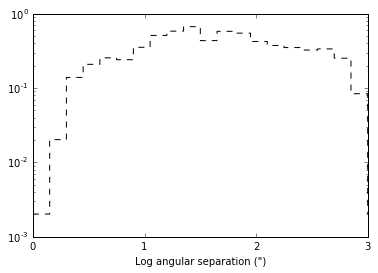

In [95]:
xmin, xmax = 0, 3


plt.hist(np.log10(TGAS_200pc['theta']), histtype='step', color='k', linestyle='dashed', bins=20, 
         range=(xmin,xmax), normed=True, label=r'$d<200$ pc', log=True)

plt.xlabel('Log angular separation (")')
plt.xticks([0, 1, 2, 3])


plt.show()

In [109]:
folder = '../data/TGAS/'

TGAS_new = np.genfromtxt(open(folder + 'gaia_wide_binaries_TGAS_plx_empirical_cleaned.txt', 'rb'), comments='^', names=True)
TGAS_old = np.genfromtxt(open(folder + 'gaia_wide_binaries_TGAS_plx_empirical.txt', 'rb'), names=True, skip_header=4)

In [131]:
dtype = [('source_id_1','<i8'),('source_id_2','<i8'),('P_posterior_1','f8'),('P_posterior_2','f8'),
         ('idx_1','i8'), ('idx_2','i8')]
compare = np.zeros(len(TGAS_new), dtype=dtype)
compare_zero = np.zeros(1, dtype=dtype)

compare['source_id_1'] = TGAS_new['source_ID_1']
compare['source_id_2'] = TGAS_new['source_ID_2']
compare['P_posterior_1'] = TGAS_new['P_posterior']
compare['idx_1'] = np.arange(len(TGAS_new))
compare['idx_2'] = -1* np.ones(len(TGAS_new))



for i in np.arange(len(TGAS_old)):
#for i in np.arange(40):
    idx1 = np.where(TGAS_old[i]['source_ID_1'] == compare['source_id_1']) 

    if len(idx1[0]) < 1: 
        compare = np.append(compare, compare_zero)
        compare[-1]['source_id_1'] = TGAS_old['source_ID_1'][i]
        compare[-1]['source_id_2'] = TGAS_old['source_ID_2'][i]
        compare[-1]['P_posterior_2'] = TGAS_old['P_posterior'][i]
        compare[-1]['idx_1'] = -1
        compare[-1]['idx_2'] = i
        continue

    j_good = -1

    for j in idx1[0]:
        if TGAS_old[i]['source_ID_2'] == compare[j]['source_id_2']:
            j_good = j

    if j_good == -1:
        compare = np.append(compare, compare_zero)
        compare[-1]['source_id_1'] = TGAS_old['source_ID_1'][i]
        compare[-1]['source_id_2'] = TGAS_old['source_ID_2'][i]
        compare[-1]['P_posterior_2'] = TGAS_old['P_posterior'][i]
        compare[-1]['idx_1'] = -1
        compare[-1]['idx_2'] = i
    else:
        compare[j_good]['P_posterior_2'] = TGAS_old['P_posterior'][i]
        compare[j_good]['idx_2'] = i




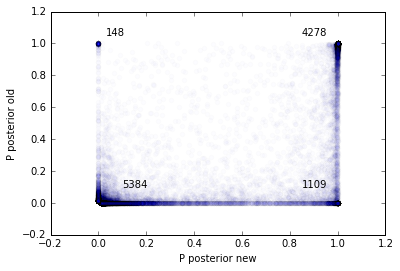

In [134]:
plt.scatter(compare['P_posterior_1'], compare['P_posterior_2'], alpha=0.01)

plt.xlabel('P posterior new')
plt.ylabel('P posterior old')

# Print numbers at bottom right and top left
idx_bottom_left = 0
idx_bottom_right = 0
idx_top_left = 0
idx_top_right = 0

for i in np.arange(len(compare)):
    
    if compare[i]['P_posterior_1'] > 0.9 and compare[i]['P_posterior_2'] > 0.9: 
        idx_top_right = np.append(idx_top_right, i)
    if compare[i]['P_posterior_1'] > 0.9 and compare[i]['P_posterior_2'] < 0.1: 
        idx_bottom_right = np.append(idx_bottom_right, i)
    if compare[i]['P_posterior_1'] < 0.1 and compare[i]['P_posterior_2'] > 0.9: 
        idx_top_left = np.append(idx_top_left, i)
    if compare[i]['P_posterior_1'] < 0.1 and compare[i]['P_posterior_2'] < 0.1: 
        idx_bottom_left = np.append(idx_bottom_left, i)

        
plt.text(0.85, 0.1, len(idx_bottom_right))
plt.text(0.1, 0.1, len(idx_bottom_left))
plt.text(0.03, 1.05, len(idx_top_left))
plt.text(0.85, 1.05, len(idx_top_right))


plt.show()

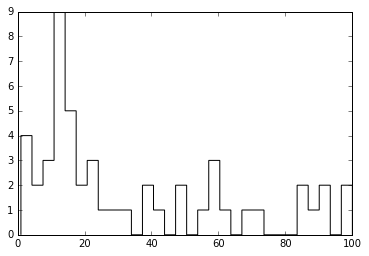

In [163]:
plt.hist(TGAS_old['theta'][compare['idx_2'][idx_top_left]], histtype='step', color='k', bins=30, range=(1, 100))
#plt.hist(TGAS_new['theta'][compare['idx_1'][compare['idx_1'] != -1]], histtype='step', color='k', bins=30, range=(1, 100))

plt.show()

In [121]:
# Calculate distance from average parallaxes, weighted by uncertainties
dist = np.zeros(len(TGAS_good))
for i in np.arange(len(TGAS_good)):
    vals = [TGAS_good['plx_1'][i],TGAS_good['plx_2'][i]]
    weights = [1.0/TGAS_good['plx_err_1'][i]**2,1.0/TGAS_good['plx_err_2'][i]**2]
    dist[i] = 1.0e3/np.average(vals, weights=weights)
    
# Calculate the physical separation in AU
s = (TGAS_good['theta']*np.pi/180.0/3600.0) * dist * (pc_to_cm/AU_to_cm)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in log10


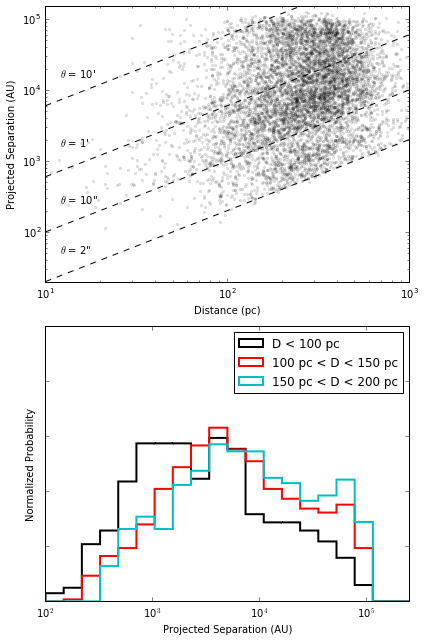

In [122]:
fig, ax = plt.subplots(2, 1, figsize=(6, 9))


tmp_x = 10**np.linspace(1,3,100)
#tmp_y_1as = (np.pi/180.0/3600.0) * tmp_x * (pc_to_cm/AU_to_cm)
tmp_y_2as = 2. * (np.pi/180.0/3600.0) * tmp_x * (pc_to_cm/AU_to_cm)
tmp_y_10as = 10. * (np.pi/180.0/3600.0) * tmp_x * (pc_to_cm/AU_to_cm)
tmp_y_60as = 60. * (np.pi/180.0/3600.0) * tmp_x * (pc_to_cm/AU_to_cm)
tmp_y_600as = 600. * (np.pi/180.0/3600.0) * tmp_x * (pc_to_cm/AU_to_cm)

ax[0].scatter(dist, s, marker='.', color='k', alpha=0.1, rasterized=True)

#plt.plot(tmp_x, tmp_y_1as, color='k', linestyle='dashed')
ax[0].plot(tmp_x, tmp_y_2as, color='k', linestyle='dashed')
ax[0].text(12.0, 50., r'$\theta$ = 2"')
ax[0].plot(tmp_x, tmp_y_10as, color='k', linestyle='dashed')
ax[0].text(12.0, 250., r'$\theta$ = 10"')
ax[0].plot(tmp_x, tmp_y_60as, color='k', linestyle='dashed')
ax[0].text(12.0, 1600., r"$\theta$ = 1'")
ax[0].plot(tmp_x, tmp_y_600as, color='k', linestyle='dashed')
ax[0].text(12.0, 15000., r"$\theta$ = 10'")



ax[0].set_xlim(10.0, 1000.0)
ax[0].set_ylim(20.0, 1.5e5)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("Distance (pc)")
ax[0].set_ylabel("Projected Separation (AU)")



idx_100 = np.where(dist<100.0)
idx_100_150 = np.intersect1d(np.where(dist<150.0)[0], np.where(dist>100.0)[0])
idx_150_200 = np.intersect1d(np.where(dist<200.0)[0], np.where(dist>150.0)[0])
idx_200 = np.where(dist<200.0)

xmin, xmax = 2.0, 5.4
ax[1].hist( np.log10(s[idx_100]), histtype='step', normed=True, linewidth=2.0,
           color='k', bins=20, range=(xmin,xmax), label='D < 100 pc')
ax[1].hist( np.log10(s[idx_100_150]), histtype='step', normed=True, linewidth=2.0, 
           color='r', bins=20, range=(xmin,xmax), label='100 pc < D < 150 pc')
ax[1].hist( np.log10(s[idx_150_200]), histtype='step', normed=True, linewidth=2.0, 
           color='c', bins=20, range=(xmin,xmax), label='150 pc < D < 200 pc')

ax[1].set_xlabel("Projected Separation (AU)")
ax[1].set_ylabel('Normalized Probability')
ax[1].set_xticks([1, 2, 3, 4, 5])
ax[1].set_xticklabels([r'10$^1$', r'10$^2$', r'10$^3$', r'10$^4$', r'10$^5$'])
ax[1].set_yticklabels([])

ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(0, 1.)
ax[1].legend(loc=1)

plt.tight_layout()
#plt.savefig('../figures/TGAS_s_distribution.pdf')
plt.show()

### Create the distance KDE

In [61]:
from scipy.stats import gaussian_kde
from scipy.integrate import quad

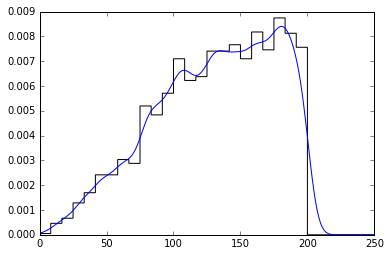

In [147]:
dist_kde = gaussian_kde(dist[dist<200.0], bw_method=0.1)

tmp_dist = np.linspace(0.0, 250.0, 200)
dist_out = dist_kde.evaluate((tmp_dist))

plt.plot(tmp_dist, dist_out)
plt.hist(dist[dist<200.0], normed=True, histtype='step', color='k', bins=30, range=(0,250.0))

plt.show()

### Create the log-flat and log-normal KDEs

In [216]:
def calc_integrand(dist, theta, dist_kde, s_kde):
    """
    This function is to calculate the integrand for the integral over distance
    
    Parameters
    ----------
    dist : float
        Distance (pc)
    theta : float
        Angular separation (arcsec)
    dist_kde : scipy gaussian_kde
        KDE based on the distance distribution observed
    s_kde : scipy gaussian_kde
        KDE based on a particular binary population model
        
    Returns
    -------
    integrand : float
        Integrand of the equation
    
    """
    
    # Get the separation in Rsun
    s = (theta / 3600.0 * np.pi/180.0) * (dist * c.pc_to_cm / c.Rsun_to_cm)
        
    # Get probability from KDE - KDE is in log-space
    P_s = s_kde.evaluate((np.log10(s))) / s / np.log(10.)

    # Projected separation is above 1.0e7 Rsun
    P_s[np.where(s > 1.0e7)] = 0.0
    
    # Get the distance probability
    P_dist = dist_kde.evaluate((dist))

    integrand = P_s * dist * P_dist 

    return integrand



def calc_integral(theta, dist_min, dist_max, dist_kde, s_kde):
    """
    Calculate the integral over distance of all binaries that 
    could match the observed angular separation, theta.
    
    Parameters
    ----------
    theta : float
        Angular separation (asec)
    dist_min, dist_max : float
        Min, max distance of integration
    dist_kde : scipy gaussian_kde
        KDE to represent distance distribution of a sample
    s_kde : scipy gaussian_kde
        KDE to represent projected physical separation distribution of a binary population

    Returns
    -------
    P_theta : float
        Value of integration
    """
    
    args = theta, dist_kde, s_kde
        
    val = quad(calc_integrand, dist_min, dist_max, args=args)
    
    return val



In [239]:
theta_min = 10.0 # 2 arcsec
theta_max = 3600.0 # 1 degree

s_min = (theta_min / 3600.0 * np.pi/180.0) * (c.pc_to_cm / c.Rsun_to_cm) 
s_max = (theta_max / 3600.0 * np.pi/180.0) * (c.pc_to_cm / c.Rsun_to_cm) 

print s_min, s_max

2138.86350236 769990.860851


In [179]:
P_binary.generate_binary_set(num_sys=100000, ecc_prob='thermal', a_prob='log_flat')
log_flat_sep_kde = gaussian_kde(P_binary.binary_set['proj_sep'], bw_method=0.05)

P_binary.generate_binary_set(num_sys=100000, ecc_prob='thermal', a_prob='raghavan')
log_normal_sep_kde = gaussian_kde(P_binary.binary_set['proj_sep'], bw_method=0.05)

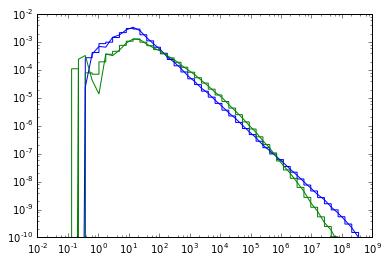

In [212]:
bins = 10**np.linspace(-2,9,50)

P_binary.generate_binary_set(num_sys=100000, ecc_prob='thermal', a_prob='log_flat')
log_flat_sep_kde = gaussian_kde(np.log10(P_binary.binary_set['proj_sep']), bw_method=0.01)
plt.hist(P_binary.binary_set['proj_sep'], bins=bins, histtype='step', normed=True)
prob_kde = log_flat_sep_kde.evaluate((np.log10(bins))) / bins / np.log(10.)
plt.plot(bins, prob_kde, color='b')


P_binary.generate_binary_set(num_sys=100000, ecc_prob='thermal', a_prob='raghavan')
log_normal_sep_kde = gaussian_kde(np.log10(P_binary.binary_set['proj_sep']), bw_method=0.01)


plt.hist(P_binary.binary_set['proj_sep'], bins=bins, histtype='step', normed=True)
prob_kde = log_normal_sep_kde.evaluate((np.log10(bins))) / bins / np.log(10.)
plt.plot(bins, prob_kde, color='g')

plt.xlim(10**(-2),10**9)
plt.ylim(1.0e-10, 1.0e-2)

plt.xscale('log')
plt.yscale('log')

plt.show()

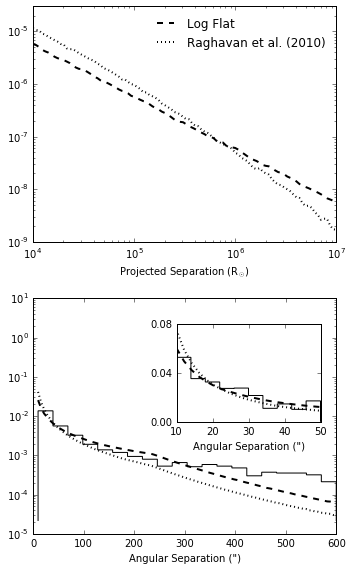

In [274]:
fig, ax = plt.subplots(2, 1, figsize=(5, 8))




proj_sep = 10**np.linspace(4,7, 100)
prob_kde =  log_flat_sep_kde.evaluate((np.log10(proj_sep))) / proj_sep / np.log(10.)
ax[0].plot(proj_sep, prob_kde, color='k', linestyle='dashed', label='Log Flat', linewidth=2.0)

prob_kde = log_normal_sep_kde.evaluate((np.log10(proj_sep))) / proj_sep / np.log(10.)
ax[0].plot(proj_sep, prob_kde, color='k', linestyle='dotted', label='Raghavan et al. (2010)', linewidth=2.0)
ax[0].set_xlabel(r'Projected Separation (R$_{\odot}$)')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim(1.0e-9, 3.0e-5)
ax[0].legend(loc=1, frameon=False)



num_samples = 100
xmin, xmax = 10, 600
idx_tmp = np.intersect1d(idx_200, np.where(TGAS_good['theta']>xmin)[0])
idx = np.intersect1d(idx_tmp, np.where(TGAS_good['theta']<xmax)[0])
tmp_theta = np.linspace(xmin, xmax, num_samples)
P_theta = np.zeros(num_samples)


# Log-flat distribution
for i in np.arange(num_samples):
    P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_kde, log_flat_sep_kde)[0]
    
weight = 1.0/np.mean(P_theta)/(xmax-xmin)
ax[1].plot(tmp_theta, P_theta * weight, color='k', linestyle='dashed', linewidth=2.0)
    
# Log-normal distribution
for i in np.arange(num_samples):
    P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_kde, log_normal_sep_kde)[0]
    
weight = 1.0/np.mean(P_theta)/(xmax-xmin)
ax[1].plot(tmp_theta, P_theta * weight, color='k', linestyle='dotted', linewidth=2.0)


# Our pairs
ax[1].hist(TGAS_good['theta'][idx], histtype='step', color='k', bins=20, log=True, normed=True,
         range=(xmin,xmax), label=r'$d < 200$ pc')

ax[1].set_xlabel('Angular Separation (")')
ax[1].set_yscale('log')

ax[1].set_ylim(1.0e-5, 10.0)






left, bottom, width, height = [0.5, 0.26, 0.4, 0.17]
ax2 = fig.add_axes([left, bottom, width, height])


num_samples = 20
xmin, xmax = 10, 50
idx_tmp = np.intersect1d(idx_200, np.where(TGAS_good['theta']>xmin)[0])
idx = np.intersect1d(idx_tmp, np.where(TGAS_good['theta']<xmax)[0])
tmp_theta = np.linspace(xmin, xmax, num_samples)
P_theta = np.zeros(num_samples)


# Log-flat distribution
for i in np.arange(num_samples):
    P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_kde, log_flat_sep_kde)[0]
    
weight = 1.0/np.mean(P_theta)/(xmax-xmin)
ax2.plot(tmp_theta, P_theta * weight, color='k', linestyle='dashed', linewidth=2.0)
    
# Log-normal distribution
for i in np.arange(num_samples):
    P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_kde, log_normal_sep_kde)[0]
    
weight = 1.0/np.mean(P_theta)/(xmax-xmin)
ax2.plot(tmp_theta, P_theta * weight, color='k', linestyle='dotted', linewidth=2.0)


# Our pairs
ax2.hist(TGAS_good['theta'][idx], histtype='step', color='k', bins=10, log=False, normed=True,
         range=(xmin,xmax), label=r'$d < 200$ pc')

ax2.set_xlabel('Angular Separation (")')
#ax2.set_yscale('log')
ax2.set_ylim(0.0, 0.08)
ax2.set_xticks([10, 20, 30, 40, 50])
ax2.set_yticks([0.0, 0.04, 0.08])



plt.tight_layout()
plt.savefig('../figures/TGAS_theta_dist.pdf')
#plt.show()